In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

### Logistic regression model

In [2]:
df = pd.read_parquet('../../data/8. data_for_modelling/Non Temporal Datasets/train_nontemporal_classification.parquet.gz')
df.shape

(300960, 123)

Feature engineering

In [4]:
# encode categorial columns as numeric
cols = ["voivodship", "powiat_voivod", "holiday_name"]
enc = OrdinalEncoder()
df[cols] = enc.fit_transform(df[cols])

# get the dummies and store it in a variable
dummies = pd.get_dummies(df["season"])
df = pd.concat([df, dummies], axis='columns')
df.drop(['season'], axis='columns')

df['CAQI_level'].replace(to_replace=['vlow', 'low', 'medium', 'high', 'vhigh'], value=[0, 1, 2, 3, 3], inplace=True)

In [5]:
# group similar cols together (and sum their values)
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Joseph%20Antony_Modelling/1.%20BaseLine%20Model.ipynb

df['emission of particules'] = df[[col for col in df.columns if col.startswith('emission of particulates ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('emission of particulates')]

df['emission of pollutant gasees'] = df[[col for col in df.columns if col.startswith('emission of pollutant gases ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('emission of pollutant gases ')]

df['total vehicles'] = df[[col for col in df.columns if col.startswith('total vehicles ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('total vehicles ')]

df['vehicles by type and fuel'] = df[[col for col in df.columns if col.startswith('vehicles by type and fuel ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('vehicles by type and fuel ')]

df['crop production'] = df[[col for col in df.columns if col.startswith('crop production ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('crop production ')]

df['air pollution reduction systems'] = df[[col for col in df.columns if col.startswith('air pollution reduction systems ')]].sum(axis=1)
df = df.loc[:, ~df.columns.str.startswith('air pollution reduction systems ')]

In [6]:
# drop cols
cols = [
    'production of electricity - water power plants and wind, biomass and wastes power plants, total',
    'production of electricity - water power plants',
    'production of electricity - thermal power plants, total',
    'production of electricity - thermal public power plants',
    'production of electricity - thermal autoproducing power plants',
    'production of electricity - from renewable energy sources',
    'production of electricity - share of renewable energy sources in total production of electricity',
    'production of electricity - relation of electricity production to electricity consumption',
    'forest fires - number of forest fires, total',
    'plants of significant nuisance - possessing systems to reduce the emission of gases',
    'plants of significant nuisance - possessing systems to reduce the emission of particulates',
    'share of green areas - share of parks, lawns and green areas of the housing estate areas in the total area',
    'season'
]
df.drop(columns=cols, inplace=True)

In [7]:
df_X = df.drop('CAQI_level', axis=1)
df_y = df['CAQI_level']

In [8]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

df_columns= df_X.columns

scaler = RobustScaler()
df_X = scaler.fit_transform(df_X)

qt = QuantileTransformer(n_quantiles=10, random_state=0)
df_X = qt.fit_transform(df_X)

df_X = pd.DataFrame(df_X)
df_X.columns = df_columns

In [9]:
X = df_X.values
y = df_y.values

#### Model training

In [10]:
from sklearn.linear_model import LogisticRegressionCV

# Cs = [0.0001, 0.001, 0.01]
cv = 4
tolerance = 1e-3
max_iter = 3000
refit = False

In [11]:
lr_model = LogisticRegressionCV(cv=cv, max_iter=max_iter, penalty="l1", solver="liblinear", multi_class="ovr", tol=tolerance, n_jobs=-1, refit=refit)
lr_model.fit(X, y)
lr_model.score(X, y)

0.5434310207336523

In [12]:
lr_model.C_

array([6.08341885e+00, 3.22889302e+02, 1.00000000e-04, 2.32579442e-02])

Feature importance

In [127]:
# select top features by looking look at sum of values per column
top_features_idx = np.argsort(np.sum(np.abs(lr_model.coef_),axis=0))[::-1]
top_feature_values = np.sort(np.sum(np.abs(lr_model.coef_),axis=0))[::-1]
top_features = df_X.columns[top_features_idx]

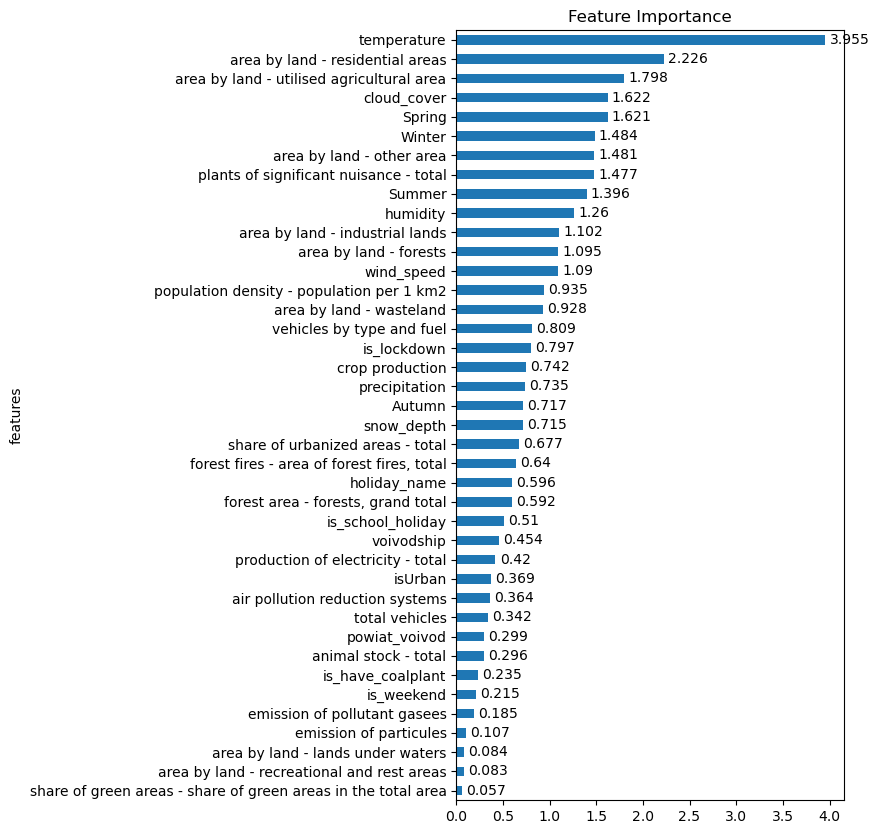

In [128]:
import matplotlib.pyplot as plt

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features': top_features,
    'importance': np.round(top_feature_values, 3)
}).set_index('features').sort_values('importance')

ax = feat_imp_df.plot(kind='barh', figsize=(5, 10))
ax.set_title("Feature Importance");
ax.bar_label(ax.containers[0], padding=3);
ax.legend().remove()

Using a different metric for Feature importance gives different weights to features

In [133]:
import math
# select top features by looking look at sum of e**(values) per column
top_features_idx = np.argsort(np.sum(pow(math.e, lr_model.coef_),axis=0))[::-1]
top_feature_values = np.sort(np.sum(pow(math.e, lr_model.coef_),axis=0))[::-1]
top_features = df_X.columns[top_features_idx]

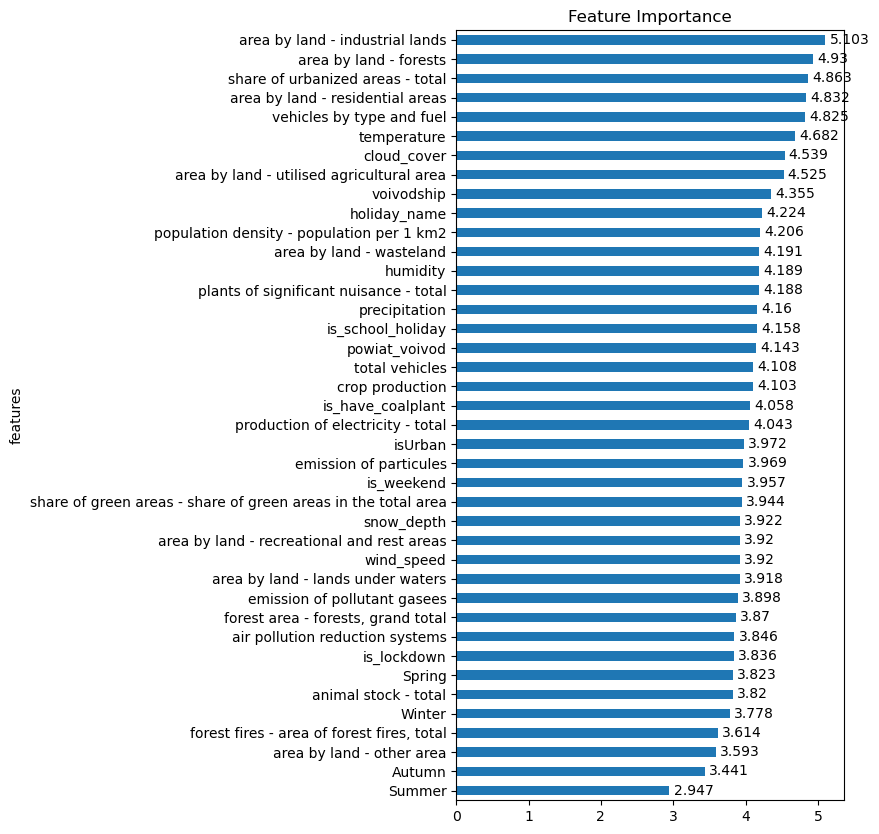

In [134]:
import matplotlib.pyplot as plt

#Creating a dataframe for feature importance
feat_imp_df = \
pd.DataFrame({
    'features': top_features,
    'importance': np.round(top_feature_values, 3)
}).set_index('features').sort_values('importance')

ax = feat_imp_df.plot(kind='barh', figsize=(5, 10))
ax.set_title("Feature Importance");
ax.bar_label(ax.containers[0], padding=3);
ax.legend().remove()

#### Model testing

In [16]:
df_test = pd.read_parquet('../../data/8. data_for_modelling/Non Temporal Datasets/test_nontemporal_classification.parquet.gz')

In [17]:
# encode categorial columns as ordinal
cols = ["season", "voivodship", "powiat_voivod", "holiday_name"]
enc = OrdinalEncoder()
df_test[cols] = enc.fit_transform(df_test[cols])

df_test['CAQI_level'].replace(to_replace=['vlow', 'low', 'medium', 'high', 'vhigh'], value=[0, 1, 2, 3, 3], inplace=True)

In [18]:
# group similar cols together (and sum their values)
# https://github.com/OmdenaAI/warsaw-poland-chapter-air-pollution/blob/main/src/tasks/task-4-modeling/Joseph%20Antony_Modelling/1.%20BaseLine%20Model.ipynb

df_test['emission of particules'] = df_test[[col for col in df_test.columns if col.startswith('emission of particulates ')]].sum(axis=1)
df_test = df_test.loc[:, ~df_test.columns.str.startswith('emission of particulates')]

df_test['emission of pollutant gasees'] = df_test[[col for col in df_test.columns if col.startswith('emission of pollutant gases ')]].sum(axis=1)
df_test = df_test.loc[:, ~df_test.columns.str.startswith('emission of pollutant gases ')]

df_test['total vehicles'] = df_test[[col for col in df_test.columns if col.startswith('total vehicles ')]].sum(axis=1)
df_test = df_test.loc[:, ~df_test.columns.str.startswith('total vehicles ')]

df_test['vehicles by type and fuel'] = df_test[[col for col in df_test.columns if col.startswith('vehicles by type and fuel ')]].sum(axis=1)
df_test = df_test.loc[:, ~df_test.columns.str.startswith('vehicles by type and fuel ')]

df_test['crop production'] = df_test[[col for col in df_test.columns if col.startswith('crop production ')]].sum(axis=1)
df_test = df_test.loc[:, ~df_test.columns.str.startswith('crop production ')]

df_test['air pollution reduction systems'] = df_test[[col for col in df_test.columns if col.startswith('air pollution reduction systems ')]].sum(axis=1)
df_test = df_test.loc[:, ~df_test.columns.str.startswith('air pollution reduction systems ')]

In [19]:
# drop cols
cols = [
    'production of electricity - water power plants and wind, biomass and wastes power plants, total',
    'production of electricity - water power plants',
    'production of electricity - thermal power plants, total',
    'production of electricity - thermal public power plants',
    'production of electricity - thermal autoproducing power plants',
    'production of electricity - from renewable energy sources',
    'production of electricity - share of renewable energy sources in total production of electricity',
    'production of electricity - relation of electricity production to electricity consumption',
    'forest fires - number of forest fires, total',
    'plants of significant nuisance - possessing systems to reduce the emission of gases',
    'plants of significant nuisance - possessing systems to reduce the emission of particulates',
    # 'share of green areas - share of parks, lawns and green areas of the housing estate areas in the total area'
]
df_test.drop(columns=cols, inplace=True)

In [20]:
df_test_X = df.drop('CAQI_level', axis=1)
df_test_y = df['CAQI_level']

In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

df_columns= df_test_X.columns

scaler = RobustScaler()
df_test_X = scaler.fit_transform(df_test_X)

qt = QuantileTransformer(n_quantiles=10, random_state=0)
df_test_X = qt.fit_transform(df_test_X)

df_test_X = pd.DataFrame(df_test_X)
df_test_X.columns = df_columns

In [22]:
X_test = df_test_X.values
y_test = df_test_y.values

In [23]:
lr_model.score(X_test,y_test)

0.5434310207336523

In [24]:
y_pred = lr_model.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error
# Calculate the mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
    
print(f"RMSE = {rmse:.3f}")

RMSE = 0.822
